In [1]:
# Import libraries
from collections import Counter, OrderedDict
from itertools import chain
from  more_itertools import unique_everseen
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import preprocessing
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plt.rcParams["font.size"] = 15
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", 500)
pd.options.display.max_colwidth = 1000
import random
import seaborn as sns
from sklearn.decomposition import PCA
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Path to file
hotels_path = "../data/clean_hotels_scraped_v2.csv"

# Dataframe
hotels_df = pd.read_csv(hotels_path, usecols = ["city", "country", "hotel_name", "rating", 
                                                "address", "popularity_rating", "locality", "price",
                                               "landmark", "URL"])

# Sanity check
hotels_df.head(2000)

city         country  \
0             Mutterstadt         Germany   
1             Mutterstadt         Germany   
2             Mutterstadt         Germany   
3             Mutterstadt         Germany   
4             Mutterstadt         Germany   
5             Mutterstadt         Germany   
6             Mutterstadt         Germany   
7             Mutterstadt         Germany   
8             Mutterstadt         Germany   
9             Mutterstadt         Germany   
10            Mutterstadt         Germany   
11            Mutterstadt         Germany   
12            Mutterstadt         Germany   
13            Mutterstadt         Germany   
14            Mutterstadt         Germany   
15            Mutterstadt         Germany   
16            Mutterstadt         Germany   
17            Mutterstadt         Germany   
18            Mutterstadt         Germany   
19            Mutterstadt         Germany   
20            Mutterstadt         Germany   
21            Mutterstadt         Germany   
22            Mutterstadt         Germany   
23            Mutterstadt         Germany   
24            Mutterstadt         Germany   
25            Mutterstadt         Germany   
26            Mutterstadt         Germany   
27            Mutterstadt         Germany   
28            Mutterstadt         Germany   
29            Mutterstadt         Germany   
30            Mutterstadt         Germany   
31            Mutterstadt         Germany   
32            Mutterstadt         Germany   
33            Mutterstadt         Germany   
34            Mutterstadt         Germany   
35            Mutterstadt         Germany   
36            Mutterstadt         Germany   
37            Mutterstadt         Germany   
38            Mutterstadt         Germany   
39            Mutterstadt         Germany   
40            Mutterstadt         Germany   
41            Mutterstadt         Germany   
42            Mutterstadt         Germany   
43            Mutterstadt         Germany   
44            Mutterstadt         Germany   
45            Mutterstadt         Germany   
46            Mutterstadt         Germany   
47            Mutterstadt         Germany   
48            Mutterstadt         Germany   
49            Mutterstadt         Germany   
50            Mutterstadt         Germany   
51            Mutterstadt         Germany   
52            Mutterstadt         Germany   
53            Mutterstadt         Germany   
54            Mutterstadt         Germany   
55            Mutterstadt         Germany   
56            Mutterstadt         Germany   
57            Mutterstadt         Germany   
58            Mutterstadt         Germany   
59            Mutterstadt         Germany   
60            Mutterstadt         Germany   
61            Mutterstadt         Germany   
62                 Passau         Germany   
63                 Passau         Germany   
64                 Passau         Germany   
65                 Passau         Germany   
66                 Passau         Germany   
67                 Passau         Germany   
68                 Passau         Germany   
69                 Passau         Germany   
70                 Passau         Germany   
71                 Passau         Germany   
72                 Passau         Germany   
73                 Passau         Germany   
74                 Passau         Germany   
75                 Passau         Germany   
76                 Passau         Germany   
77                 Passau         Germany   
78                 Passau         Germany   
79                 Passau         Germany   
80                 Passau         Germany   
81                 Passau         Germany   
82                 Passau         Germany   
83                 Passau         Germany   
84                 Passau         Germany   
85                 Passau         Germany   
86                Hamburg         Germany   
87                Hamburg         Germany   
88              

In [3]:
hotels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426680 entries, 0 to 426679
Data columns (total 10 columns):
city                 426680 non-null object
country              426680 non-null object
hotel_name           426680 non-null object
rating               426680 non-null float64
address              426680 non-null object
popularity_rating    426680 non-null float64
locality             426680 non-null object
price                426680 non-null float64
landmark             426680 non-null object
URL                  426680 non-null object
dtypes: float64(3), object(7)
memory usage: 32.6+ MB


In [4]:
hotels_df.nunique()

city                  22796
country                 198
hotel_name            71528
rating                    9
address               71809
popularity_rating       999
locality              22083
price                   745
landmark             290864
URL                  322179
dtype: int64

In [5]:
def get_model():
    """ Return model architecture and weights """

    # Import embeddings model and weights
    model = models.load_model("../models/nn_scraped_hotels.h5")
    model.load_weights("../models/nn_scraped_hotels_weights.h5")
    return model

def get_int_mapping(dataframe, column):
    """ Returns index, reverse_index, and list of unique items in a pandas datframe """

    # Convert series to list
    column_to_list = dataframe[column].tolist()

    # Find set of unique items and convert to a list
    unique_items_list = list(unique_everseen(column_to_list))

    # Create indexes for each item
    item_index = {item: idx for idx, item in enumerate(unique_items_list)}
    index_item = {idx: item for item, idx in item_index.items()}

    return item_index, index_item, unique_items_list

def get_embeddings(layer_name):
    """ Given a model and a layer name, this function returns the 
    normalized embedding [weights] for said layer """

    # Get model
    model = get_model()

    # Get layer
    item_layer = model.get_layer(layer_name)

    # Get weights
    item_weights = item_layer.get_weights()[0]

    # Normalize the embeddings so that we can calculate cosine similarity
    item_weights = item_weights / np.linalg.norm(item_weights, axis = 1).reshape((-1, 1))

    return item_weights

In [6]:
city_index, index_city, unique_cities = get_int_mapping(hotels_df, "city")
country_index, index_country, unique_countries = get_int_mapping(hotels_df, "country")
hotel_index, index_hotel, unique_hotels = get_int_mapping(hotels_df, "hotel_name")
locality_index, index_locality, unique_localities = get_int_mapping(hotels_df, "locality")
landmark_index, index_landmark, unique_landmarks = get_int_mapping(hotels_df, "landmark")
price_index, index_price, unique_prices = get_int_mapping(hotels_df, "price")
rating_index, index_rating, unique_ratings = get_int_mapping(hotels_df, "rating")
popularity_index, index_popularity, unique_popularities = get_int_mapping(hotels_df, "popularity_rating")

In [7]:
# Extract embeddings
city_weights = get_embeddings("city_embedding")
country_weights = get_embeddings("country_embedding")
hotel_weights = get_embeddings("hotel_embedding")
rating_weights = get_embeddings("rating_embedding")
popularity_weights = get_embeddings("popularity_embedding")
locality_weights = get_embeddings("locality_embedding")
price_weights = get_embeddings("price_embedding")
landmark_weights = get_embeddings("landmark_embedding")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
def find_similar(name, weights, index_name = "hotel_name", n = 10, 
                        plot = False, filtering = False, filter_name = None):
    """ Return most similar items """

    # Select index and reverse index
    if index_name == "city":
        index = city_index
        rindex = index_city
    if index_name == "country":
        index = country_index
        rindex = index_country
    if index_name == "hotel_name":
        index = hotel_index
        rindex = index_hotel
    if index_name == "rating":
        index = rating_index
        rindex = index_rating
    if index_name == "popularity_rating":
        index = popularity_index
        rindex = index_popularity
    if index_name == "locality":
        index = locality_index
        rindex = index_locality
    if index_name == "price":
        index = price_index
        rindex = index_price
    if index_name == "landmark":
        index = landmark_index
        rindex = index_landmark

    # Check name is in index
    try:
        # Calculate dot product between item/property and all others
        distances = np.dot(weights, weights[index[name]])
    except KeyError:
        print(" {} Not Found.".format(name))
        return
    
    # Sort distances from smallest to largest
    sorted_distances = np.argsort(distances)
        
    # Find the most similar
    closest = sorted_distances[-n:]

    # Limit results by filtering
    filter_ = None
    hotel_name = []
    city = []
    country = []
    url = []
    landmark = []
    locality = []
    rating = []

    # Limit results by filtering
    filter_ = None
    filtered_results = []
    if filtering:
        for idxs, rows in hotels_df.iterrows():
            if hotels_df.at[idxs, index_name] == name:
                filter_ = hotels_df.at[idxs, filter_name]
                break
        match_df = hotels_df[hotels_df[filter_name].str.match(filter_)]
        match_df = match_df.reset_index(drop = True)
        match_df["distance"] = None
        for idxs, rows in match_df.iterrows():
            item = match_df.at[idxs, index_name]
            distance = np.dot(weights[index[item]], weights[index[name]])
            match_df.loc[match_df.index[idxs], "distance"] = distance
        match_df = match_df.sort_values(by = ["distance"], axis = 0, ascending = False)
        list_of_filtered_items = match_df[index_name].to_list()
        list_of_filtered_distances = match_df["distance"].to_list()
        list_of_filtered_results = list(zip(list_of_filtered_items, list_of_filtered_distances))
        for item in list_of_filtered_results[1:]:
            if item not in filtered_results:
                filtered_results.append(item)     
        if plot:
            # Find closest and most far away item
            closest = filtered_results[:n // 2]
            far_away = filtered_results[-n-1: len(filtered_results) - 1]
            to_plot = [c[0] for c in closest]
            to_plot.extend(c[0] for c in far_away)

            # Find distances 
            dist = [c[1] for c in closest]
            dist.extend(c[1] for c in far_away)  

            # Colors
            colors = ["darkturquoise" for _ in range(n)]
            colors.extend("hotpink" for _ in range(n // 2))

            # Data in DataFrame
            data = pd.DataFrame({"distance": dist}, index = to_plot)

            # Bar chart
            data["distance"].plot.barh(color = colors, figsize = (10, 8), edgecolor = "k", linewidth = 2)
            plt.xlabel("Cosine Similarity");
            plt.axvline(x = 0, color = "k");

            # Title
            name_str = "Most and Least Similar to {}".format(name)
            plt.title(name_str, x = 0.2, size = 28, y = 1.05)
            return None
        
        return filtered_results

    # Plot results if True
    if plot:
        # Find closest and most far away item
        far_away = sorted_distances[:n // 2]
        closest = sorted_distances[-n-1: len(distances) - 1]
        to_plot = [rindex[c] for c in far_away]
        to_plot.extend(rindex[c] for c in closest)
        
        # Find distances 
        dist = [distances[c] for c in far_away]
        dist.extend(distances[c] for c in closest)
        
        # Colors
        colors = ["hotpink" for _ in range(n // 2)]
        colors.extend("darkturquoise" for _ in range(n))
        
        # Data in DataFrame
        data = pd.DataFrame({"distance": dist}, index = to_plot)
        
        # Bar chart
        data["distance"].plot.barh(color = colors, figsize = (10, 8), edgecolor = "k", linewidth = 2)
        plt.xlabel("Cosine Similarity");
        plt.axvline(x = 0, color = "k");
        
        # Title
        name_str = "Most and Least Similar to {}".format(name)
        plt.title(name_str, x = 0.2, size = 28, y = 1.05)
        
        return None
        
    # Print the most similar and distances
    for c in reversed(closest):
        print("{}: {} Similarity: {}".format(index_name.capitalize(), rindex[c], distances[c], 2))

In [27]:
find_similar("W", hotel_weights, filtering = True, filter_name = "city", plot = True)

 W Not Found.


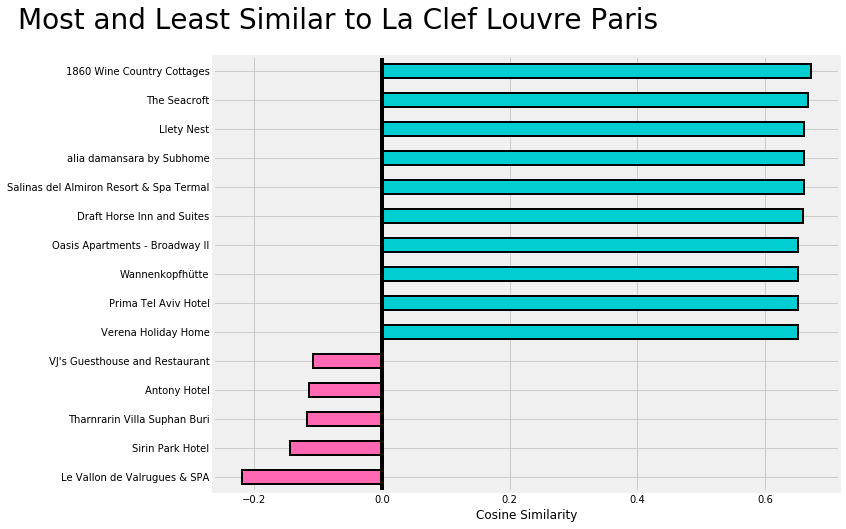

In [21]:
find_similar("La Clef Louvre Paris", hotel_weights, plot = True)

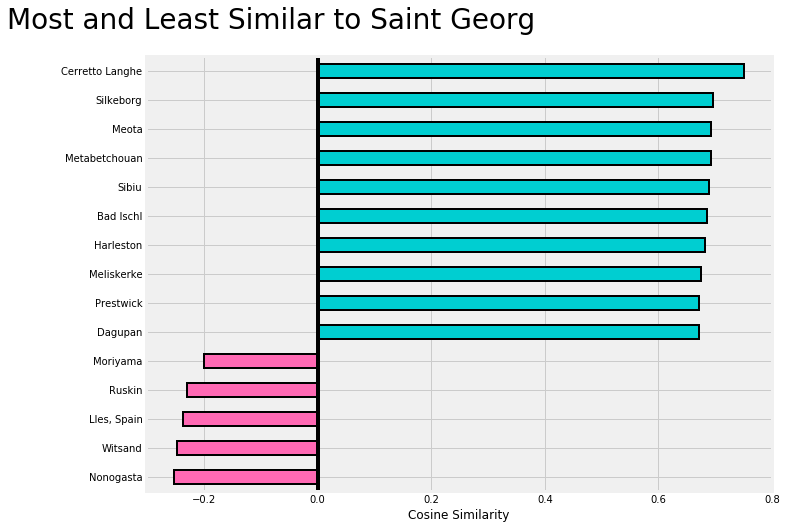

In [22]:
find_similar("Saint Georg", locality_weights, index_name = "locality", plot = True)

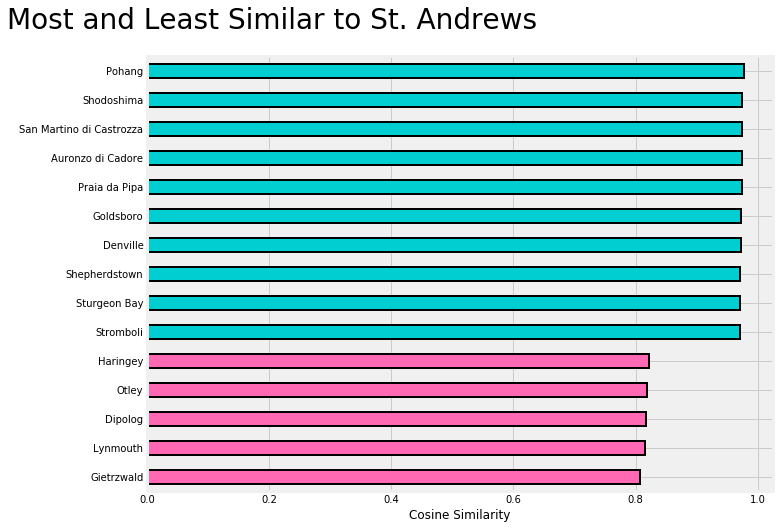

In [28]:
find_similar("St. Andrews", city_weights, index_name = "city", plot = True)

In [9]:
# Use PCA
pca = PCA(n_components = 4)
pca_result = pca.fit_transform(hotel_weights)

pca_df = pd.DataFrame(columns = ["pc1", "pc2", "pc3", "pc4"])

pca_df["pc1"] = pca_result[:, 0]
pca_df["pc2"] = pca_result[:, 1]
pca_df["pc3"] = pca_result[:, 2]
pca_df["pc4"] = pca_result[:, 3]

In [11]:
def count_items(list_items):
    
    # Create a counter object
    counts = Counter(list_items)
    
    # Sort by highest count first and place in ordered dictionary
    counts = sorted(counts.items(), key = lambda x: x[1], reverse = True)
    counts = OrderedDict(counts)
    
    return counts

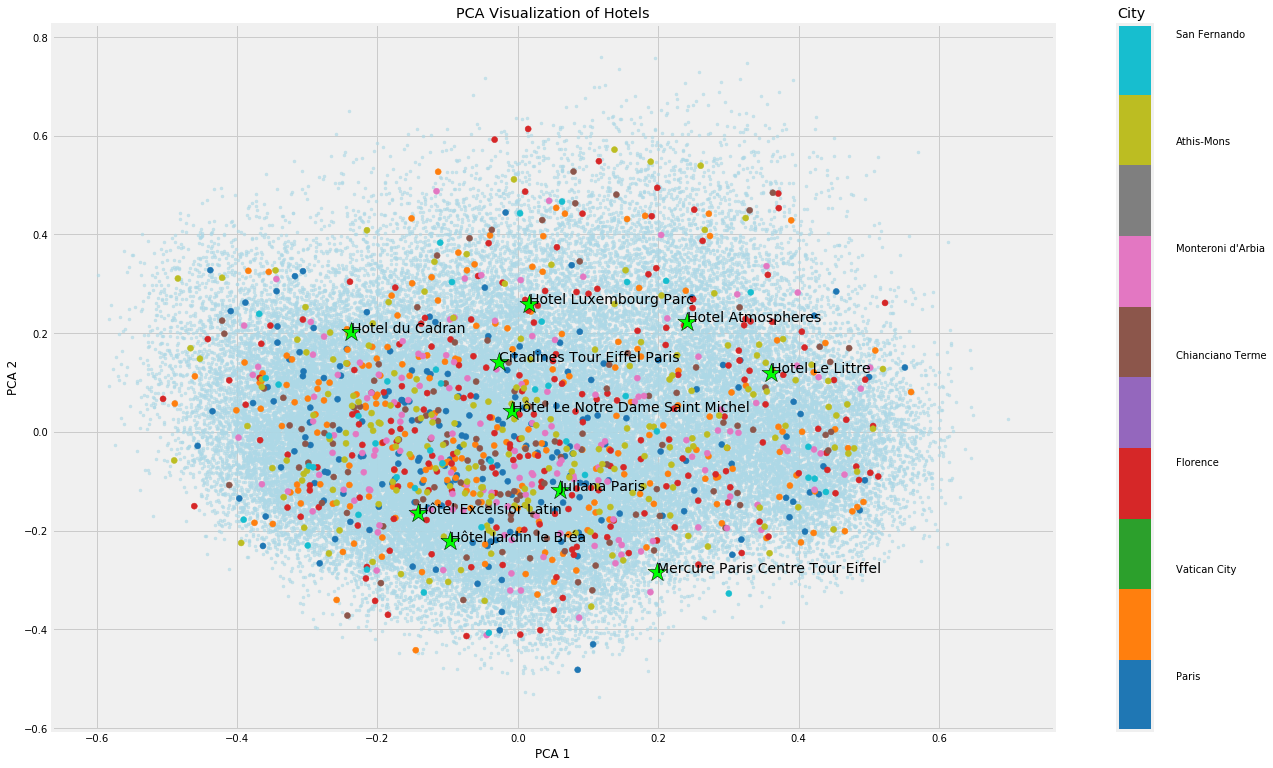

In [29]:
# Get top ten cities
city_counts = count_items(hotels_df["city"].to_list())
list(city_counts.items())[:20]

# Select which cities to include
cities_to_include = list(city_counts.keys())[:10]

idx_include = []
cities = []
hotels = []

for index, row in hotels_df.iterrows():
    if index < len(hotel_weights):
        if hotels_df.at[index, "city"] in cities_to_include:
            idx_include.append(index)
            cities.append(hotels_df.at[index, "city"])
            hotels.append(hotels_df.at[index, "hotel_name"])
            
# Map cities to integers to plot them as colors
ints, cit = pd.factorize(cities)

plt.figure(figsize = (20,13))

# Plot all hotels
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker = ".", color = "lightblue", alpha = 0.6)

# Plot embedding
plt.scatter(pca_result[idx_include, 0], pca_result[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(cit):
    cbar.ax.text(10, (2 * j + 1) / ((1.1) * 2), lab, ha = "left", va = "center")
cbar.ax.set_title("City", loc = "left")
cbar.ax.get_yaxis().labelpad = 15


plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Visualization of Hotels");

for hotel in hotels[:10]:
    
    x, y = pca_result[hotel_index[hotel], 0], pca_result[hotel_index[hotel], 1];
    _ = plt.scatter(x, y, s = 400, color = "lime", marker = "*", edgecolor = "k")
    _ = plt.text(x, y, hotel, fontsize = 14);

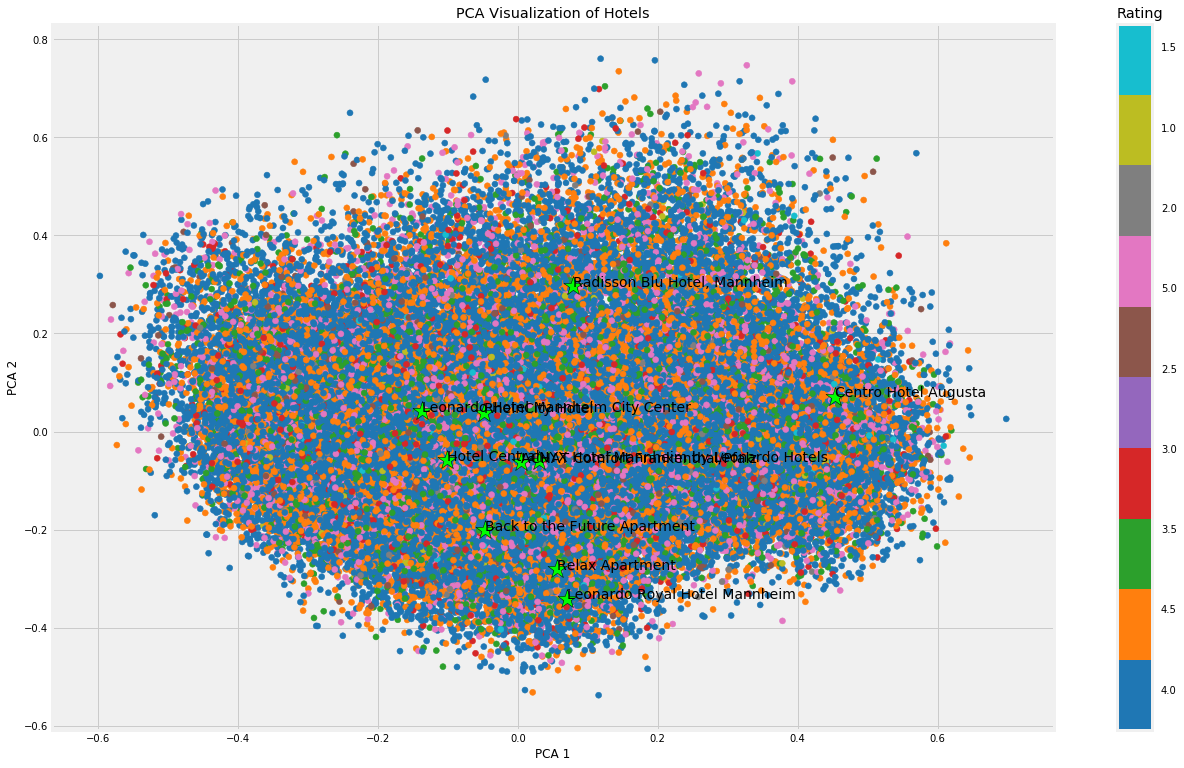

In [25]:
# Get top ten ratings
rating_counts = count_items(hotels_df["rating"].to_list())
list(rating_counts.items())[:20]

# Include all rating categories
ratings_to_include = list(rating_counts.keys())[:10]

idx_include = []
ratings = []
hotels = []

for index, row in hotels_df.iterrows():
    if index < len(hotel_weights):
        if hotels_df.at[index, "rating"] in ratings_to_include:
            idx_include.append(index)
            ratings.append(hotels_df.at[index, "rating"])
            hotels.append(hotels_df.at[index, "hotel_name"])
            
# Map ratings to integers to plot them as colors
ints, rat = pd.factorize(ratings)

plt.figure(figsize = (20,13))

# Plot all hotels
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker = ".", color = "lightblue", alpha = 0.6)

# Plot embedding
plt.scatter(pca_result[idx_include, 0], pca_result[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(rat):
    cbar.ax.text(10, (2 * j + 1) / ((1.1) * 2), lab, ha = "left", va = "center")
cbar.ax.set_title("Rating", loc = "left")
cbar.ax.get_yaxis().labelpad = 15


plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Visualization of Hotels");

for hotel in hotels[:10]:
    
    x, y = pca_result[hotel_index[hotel], 0], pca_result[hotel_index[hotel], 1];
    _ = plt.scatter(x, y, s = 400, color = "lime", marker = "*", edgecolor = "k")
    _ = plt.text(x, y, hotel, fontsize = 14);

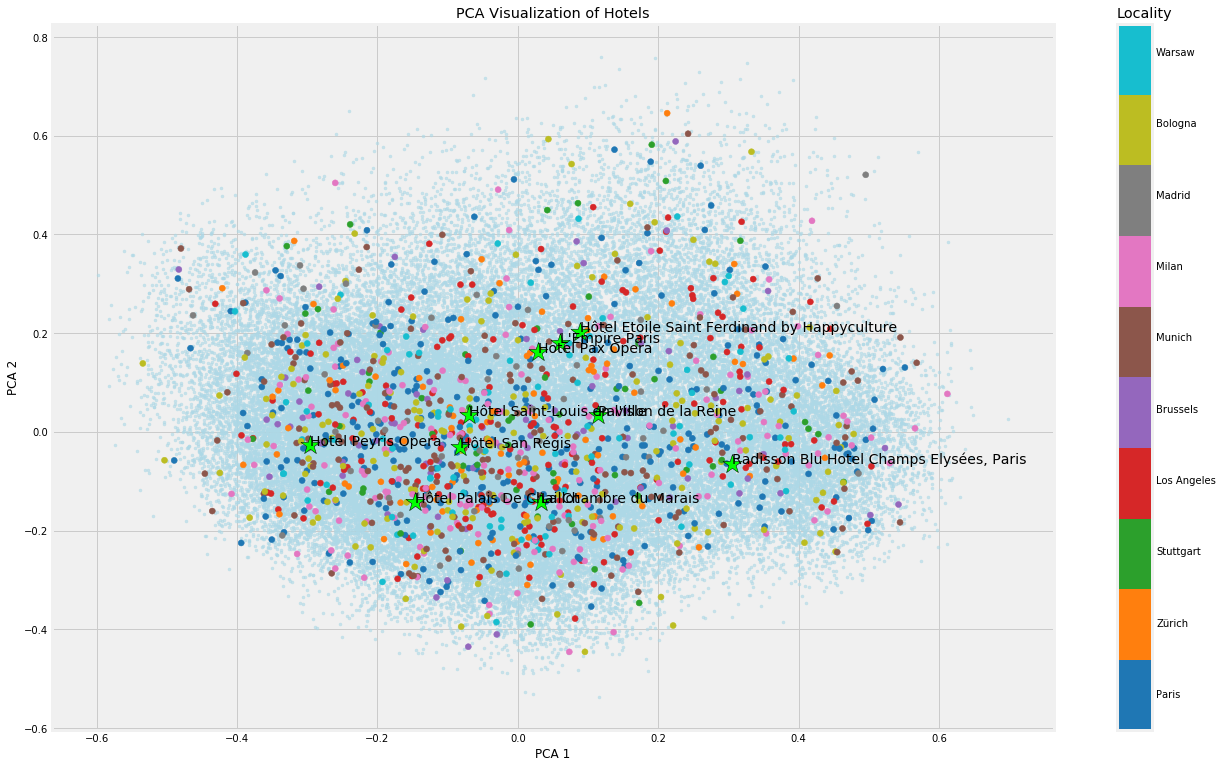

In [26]:
# Get top ten localities
locality_counts = count_items(hotels_df["locality"].to_list())
list(locality_counts.items())[:20]

# Include 10 most popular localities
localities_to_include = list(locality_counts.keys())[:10]

idx_include = []
localities = []
hotels = []

for index, row in hotels_df.iterrows():
    if index < len(hotel_weights):
        if hotels_df.at[index, "locality"] in localities_to_include:
            idx_include.append(index)
            localities.append(hotels_df.at[index, "locality"])
            hotels.append(hotels_df.at[index, "hotel_name"])
            
# Map localities to integers to plot them as colors
ints, loc = pd.factorize(localities)

plt.figure(figsize = (20,13))

# Plot all hotels
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker = ".", color = "lightblue", alpha = 0.6)

# Plot embedding
plt.scatter(pca_result[idx_include, 0], pca_result[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(loc):
    cbar.ax.text(10, (2 * j + 1) / ((1.1) * 2), lab, ha = "left", va = "center")
cbar.ax.set_title("Locality", loc = "left")
cbar.ax.get_yaxis().labelpad = 15


plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Visualization of Hotels");

for hotel in hotels[:10]:
    
    x, y = pca_result[hotel_index[hotel], 0], pca_result[hotel_index[hotel], 1];
    _ = plt.scatter(x, y, s = 400, color = "lime", marker = "*", edgecolor = "k")
    _ = plt.text(x, y, hotel, fontsize = 14);

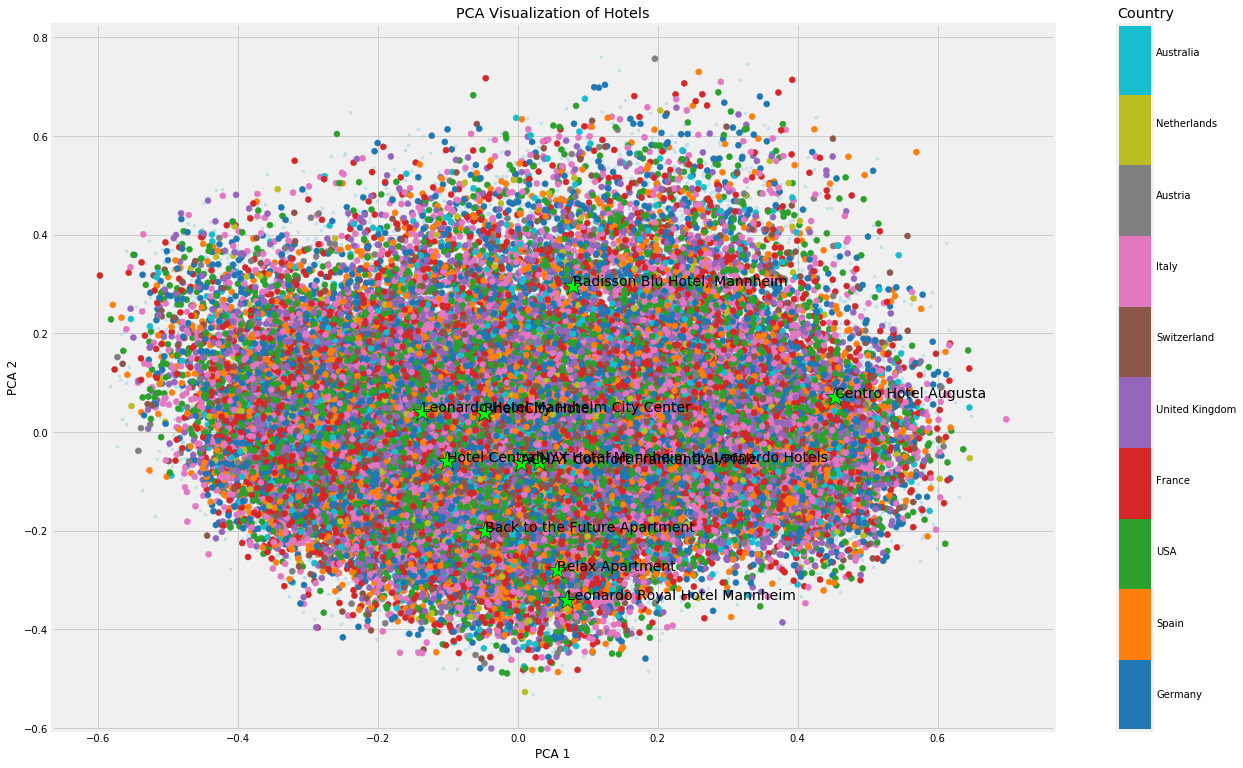

In [30]:
# Get top ten countries
country_counts = count_items(hotels_df["country"].to_list())
list(country_counts.items())[:20]

# Include 10 most popular localities
countries_to_include = list(country_counts.keys())[:10]

idx_include = []
countries = []
hotels = []

for index, row in hotels_df.iterrows():
    if index < len(hotel_weights):
        if hotels_df.at[index, "country"] in countries_to_include:
            idx_include.append(index)
            countries.append(hotels_df.at[index, "country"])
            hotels.append(hotels_df.at[index, "hotel_name"])
            
# Map localities to integers to plot them as colors
ints, cnt = pd.factorize(countries)

plt.figure(figsize = (20,13))

# Plot all hotels
plt.scatter(pca_result[:, 0], pca_result[:, 1], marker = ".", color = "lightblue", alpha = 0.6)

# Plot embedding
plt.scatter(pca_result[idx_include, 0], pca_result[idx_include, 1], 
            c = ints, cmap = plt.cm.tab10)

# Add colorbar and appropriate labels
cbar = plt.colorbar()
cbar.ax.get_yaxis().set_ticks([])
for j, lab in enumerate(cnt):
    cbar.ax.text(10, (2 * j + 1) / ((1.1) * 2), lab, ha = "left", va = "center")
cbar.ax.set_title("Country", loc = "left")
cbar.ax.get_yaxis().labelpad = 15


plt.xlabel("PCA 1"); plt.ylabel("PCA 2"); plt.title("PCA Visualization of Hotels");

for hotel in hotels[:10]:
    
    x, y = pca_result[hotel_index[hotel], 0], pca_result[hotel_index[hotel], 1];
    _ = plt.scatter(x, y, s = 400, color = "lime", marker = "*", edgecolor = "k")
    _ = plt.text(x, y, hotel, fontsize = 14);